In [3]:
import math
import copy
import random
import numpy as np
import pickle
import heapq
import matplotlib.pyplot as plt

In [4]:
def gridToImage(grid, color_dict):
    grid = copy.deepcopy(grid)
    for row in grid:
        for i in range(len(row)):
            row[i] = color_dict.get(row[i], [0, row[i], 0])
    plt.imshow(grid)
    plt.show()

def showPath(start, end, grid, path):
    grid = copy.deepcopy(grid)
    for n in path:
        grid[n[1]][n[0]] = 7

    grid[start[1]][start[0]] = 'S'
    grid[end[1]][end[0]] = 'E'

    color_dict = {
        0 : [255, 255, 255],
        1 : [0, 0, 0],
        7 : [0, 255, 0],
        'S' : [0, 0, 255],
        'E' : [255, 0, 0]
    }

    gridToImage(grid, color_dict)

def showValues(start, end, grid):
    grid = copy.deepcopy(grid)
    max_value = max([max(row) for row in grid])
    for row in grid:
        for i in range(len(row)):
            if isinstance(row[i], int) and row[i] == 1:
                row[i] = 'O'
            elif isinstance(row[i], float):
                row[i] /= max_value

    grid[start[1]][start[0]] = 'S'
    grid[end[1]][end[0]] = 'E'

    color_dict = {
        0 : [255, 255, 255],
        'O' : [0, 0, 0],
        7 : [0, 255, 0],
        'S' : [0, 0, 255],
        'E' : [255, 0, 0]
    }

    gridToImage(grid, color_dict)

In [5]:
class Node:

    def __init__(self, pos, parent=None):
        self.pos = tuple(pos)
        self.parent = parent
        self.g = 0 # cost of path from n to start
        self.h = 0 # estimated cost of path from n to end
        self.f = 0 # total cost = g + h

    def __eq__(self, other):
        return self.pos[0] == other.pos[0] and self.pos[1] == other.pos[1]
    
    def __hash__(self):
        return hash(self.pos)
    

In [6]:
import heapq

### Create cost grid

In [7]:
def create_cost_grid(grid, check_range):
    new_grid = copy.deepcopy(grid)

    for r in range(len(grid)):
        for c in range(len(grid[0])):
            if grid[r][c] == 1:
                if c == 0 or grid[r][c - 1] == 1:
                    left_check = 0
                else:
                    left_check = -check_range

                if c == len(grid[0]) - 1 or grid[r][c + 1] == 1:
                    right_check = 0
                else:
                    right_check = check_range

                if r == len(grid) - 1 or grid[r + 1][c] == 1:
                    up_check = 0
                else:
                    up_check = check_range

                if r == 0 or grid[r - 1][c] == 1:
                    down_check = 0
                else:
                    down_check = -check_range

                for dx in range(left_check, right_check + 1):
                    for dy in range(down_check, up_check + 1):
                        x, y = c + dx, r + dy
                        if 0 <= x < len(grid[0]) and 0 <= y < len(grid) and grid[y][x] != 1:
#                            cost = max(0, (check_range**2) - (dx**2 + dy**2))
#                            cost = min((check_range**2), (check_range**2) / (dx**2 + dy**2))
                            cost = min((check_range**2), (check_range**2) / math.sqrt(dx**2 + dy**2))
#                            cost = (check_range**2) / (abs(dx) + abs(dy))
                            new_grid[y][x] = max(new_grid[y][x], cost)

    return new_grid

In [8]:
def astar(start, end, graph, cost_grid=[]):
    """
    Returns the path traversing graph using a* search

    Parameters
    ----------
    start : tuple or list
        (x, y)
    end : tuple or list
        (x, y)
    graph : 2d list
        graph to traverse
    cost_grid: 2d list
        adds a penalty

    Returns
    -------
    list of (x, y) or False
        path from start to end if found
    """

    open_list = []
    closed_list = set()

    start_node = Node(start)
    index = 0
    open_list.append((start_node.f, index, start_node))
    heapq.heapify(open_list)

    while len(open_list) > 0:
        start_node = heapq.heappop(open_list)[-1]
        closed_list.add(start_node)

        for dir in [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (1, -1), (-1, -1), (-1, 1)]:
            x = dir[0]
            y = dir[1]

            node = Node((start_node.pos[0] + x, start_node.pos[1] + y), start_node)
            if node.pos[0] < 0:
                continue
            if node.pos[0] >= len(graph[0]):
                continue
            if node.pos[1] < 0:
                continue
            if node.pos[1] >= len(graph):
                continue

            if node in closed_list:
                continue

            if graph[node.pos[1]][node.pos[0]] == 1:
                continue

            node.g = start_node.g + math.sqrt(math.pow(start_node.pos[0] - node.pos[0], 2) + math.pow(start_node.pos[1] - node.pos[1], 2))
            dup = any(node == n[-1] and n[-1].g <= node.g for n in open_list)
            if dup:
                continue

            node.h = math.sqrt(math.pow(end[0] - node.pos[0], 2) + math.pow(end[1] - node.pos[1], 2))
            node.f = node.g + node.h
            if len(cost_grid) != 0:
                node.f += cost_grid[node.pos[1]][node.pos[0]]


            if node.pos[0] == end[0] and node.pos[1] == end[1]:
                path = []
                while node is not None:
                    path.append(node.pos)
                    node = node.parent

                path = path[::-1]
                return path

            index += 1
            heapq.heappush(open_list, (node.f, index, node))

    return []

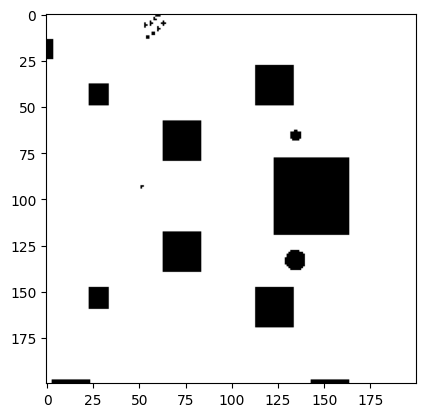

In [9]:
with open('occupancy_map.pickle', "rb") as f:
    original_data = pickle.load(f)

plt.imshow(original_data, cmap='Greys')

In [ ]:
def prune_path(path):
    new_path = [path[0]]
    for i in range(1, len(path) - 1):
        dx = path[i][0] - path[i+1][0]
        dx2 = path[i-1][0] - path[i][0]

        dy = path[i][1] - path[i+1][1]
        dy2 = path[i-1][1] - path[i][1]

        if dx == dx2 and dy == dy2:
            continue
        new_path.append(path[i])
    new_path.append(path[-1])
    return new_path

In [11]:
def drawLine(start, end, grid):
    grid = copy.deepcopy(grid)

    x1, y1 = start
    x2, y2 = end

    dy = y2 - y1
    dx = x2 - x1

    length = math.sqrt(dy**2 + dx**2)
    vx = dx / length
    vy = dy / length

    for t in range(1, math.floor(length)):
        x = x1 + t * vx
        y = y1 + t * vy

        grid[math.floor(y), math.floor(x)] = 10
        grid[math.ceil(y), math.ceil(x)] = 10
    
    return grid

In [12]:
def isLineOfSightBlocked(start, end, grid, threshold):
    grid = copy.deepcopy(grid)

    x1, y1 = start
    x2, y2 = end

    dy = y2 - y1
    dx = x2 - x1

    length = math.sqrt(dy**2 + dx**2)
    vx = dx / length
    vy = dy / length

    for t in range(1, math.floor(length)):
        x = x1 + t * vx
        y = y1 + t * vy

        floor_cell = grid[math.floor(y), math.floor(x)]
        ceil_cell = grid[math.ceil(y), math.ceil(x)]

        if floor_cell >= threshold or floor_cell == 1 or ceil_cell >= threshold or ceil_cell == 1:
            return True
    
    return False

In [13]:
def line_of_sight_path(path, grid, threshold):
    new_path = []

    i = 0
    while i < len(path):
        start = path[i]
        new_path.append(start)
        for j in range(len(path) - 1, i, -1):
            end = path[j]
            if not isLineOfSightBlocked(start, end, grid, threshold):
                new_path.append(end)
                i = j
                break

        i += 1

    return new_path

In [ ]:
def is_blocked(point, grid, threshold):
    cell = grid[point[1], point[0]]
    if cell >= threshold or cell == 1:
        return True
    return False

In [ ]:
def get_intersection(start, end, grid, threshold):
    grid = copy.deepcopy(grid)

    x1, y1 = start
    x2, y2 = end

    start_blocked = grid[y1, x1] >= threshold or grid[y1, x1] == 1

    dy = y2 - y1
    dx = x2 - x1

    length = math.sqrt(dy**2 + dx**2)
    vx = dx / length
    vy = dy / length

    for t in range(1, math.floor(length)):
        x = x1 + t * vx
        y = y1 + t * vy

        floor_cell = (math.floor(x), math.floor(y))
        ceil_cell = (math.ceil(x), math.ceil(y))

        if is_blocked(floor_cell, grid, threshold) or is_blocked(ceil_cell, grid, threshold):
            if not start_blocked:
                t -= 1

                x = x1 + t * vx
                y = y1 + t * vy

                round_cell = (round(x), round(y))

                return round_cell
        else:
            if start_blocked:
                t += 1

                x = x1 + t * vx
                y = y1 + t * vy

                round_cell = (round(x), round(y))

                return round_cell

    return ()

In [15]:
def is_line_of_sight_blocked(start, end, grid, threshold):
    x1, y1 = start
    x2, y2 = end

    dy = y2 - y1
    dx = x2 - x1

    length = math.sqrt(dy**2 + dx**2)
    vx = dx / length
    vy = dy / length

    for t in range(1, math.floor(length) + 1):
        x = x1 + t * vx
        y = y1 + t * vy

        floor_cell = (math.floor(x), math.floor(y))
        ceil_cell = (math.ceil(x), math.ceil(y))

        if is_blocked(floor_cell, grid, threshold) or is_blocked(ceil_cell, grid, threshold):
            return True

    return False

In [ ]:
def fix_path(path, grid, costs, threshold):
    data_cost = create_cost_grid(grid, costs)
    print(f'Inital path: {path}')

    # remove duplicates
#    path = list(dict.fromkeys(path))

    new_points = []
    for i in range(0, len(path) - 1):
        new_points.append(path[i])
        intersection = get_intersection(path[i], path[i+1], data_cost, threshold)
        if len(intersection) != 0:
            new_points.append(intersection)
    new_points.append(path[-1])

    new_points = [point for point in new_points[1:-1] if not is_blocked(point, data_cost, threshold)]
    new_points.insert(0, path[0])
    new_points.append(path[-1])

    # remove duplicates
    new_points = list(dict.fromkeys(new_points))

    new_path = []
    for i in range(0, len(new_points) - 1):
        if is_line_of_sight_blocked(new_points[i], new_points[i+1], data_cost, threshold):
            path_between_points = astar(new_points[i], new_points[i+1], grid, data_cost)
        else:
            path_between_points = [new_points[i], new_points[i+1]]
        new_path += path_between_points[:-1]
    new_path.append(path[-1])

#    new_path = prune_path(new_path)
#    new_path = line_of_sight_path(new_path, data_cost, threshold)

#    print(f'Final path: {new_path}')
    return new_path

### Work

In [28]:
data = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
]
data = np.array(data, dtype=float)

data_cost = create_cost_grid(data, 5)

plt.imshow(data_cost, cmap='Blues')

Inital path: [(8, 3), (7, 6), (7, 10), (19, 10)]
Final path: [(8, 3), (7, 2), (3, 2), (2, 3), (2, 10), (3, 11), (8, 11), (19, 10)]


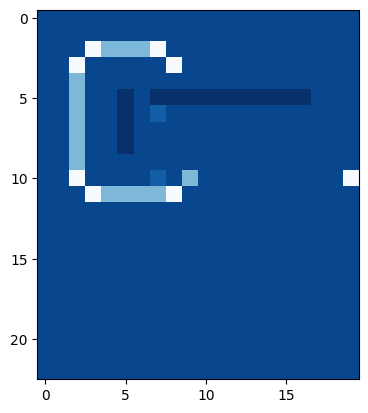

In [59]:
data = [
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
]
data = np.array(data, dtype=float)

data_cost = create_cost_grid(data, 5)
path = astar((0, 10), (19, 10), data, cost_grid=data_cost)

#data[14, 12] = 1
#data[15, 12] = 1
#data[16, 12] = 1
#data[17, 12] = 1
#data[17, 11] = 1
#data[17, 10] = 1
#data[18, 12] = 1
#data[19, 12] = 1
#data[20, 12] = 1
#
#data[21, 12] = 1
#
#data[7, 13] = 1
#data[7, 14] = 1
#data[7, 15] = 1
#data[7, 16] = 1
#data[7, 17] = 1

grid = copy.deepcopy(data)
for x, y in path:
    grid[y][x] = -1

path = prune_path(path)
path = line_of_sight_path(path, data_cost, 5)

path = fix_path(path, data, 5, 5)

data_cost = create_cost_grid(data, 5) 
for x, y in path:
    grid[y][x] = -5

path = prune_path(path)
path = line_of_sight_path(path, data_cost, 5)
for x, y in path:
    grid[y][x] = -10

print(f'Final path: {path}')

plt.imshow(grid, cmap='Blues')

In [ ]:
path

Inital path: [(0, 10), (11, 15), (13, 15), (17, 11), (19, 10)]
Final path: [(0, 10), (8, 14), (8, 16), (11, 19), (11, 21), (12, 22), (17, 17), (19, 10)]


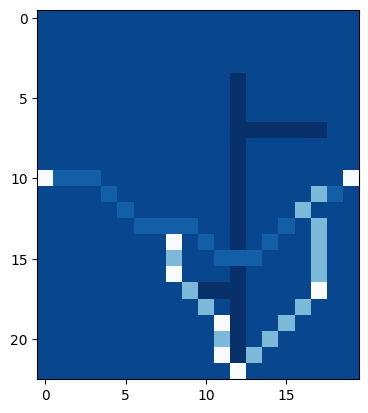

In [38]:
path[1:-1]

In [ ]:
data = original_data.copy()

C = 10
data_cost = create_cost_grid(data, C)
path = astar((0, 0), (199, 199), data, cost_grid=data_cost)

path = prune_path(path)
path = line_of_sight_path(path, data_cost, (C**2) / 5)

#path = fix_path(path, data, [10, 5, 2.5, 1], 10)

grid = copy.deepcopy(data_cost)
for x, y in path:
    grid[y][x] = max([max(row) for row in grid])
plt.imshow(grid, cmap='Greys')

In [ ]:
data = original_data.copy()

data_cost = create_cost_grid(data, 10)
path = astar((0, 0), (199, 199), data, cost_grid=data_cost)

path = prune_path(path)
path = line_of_sight_path(path, data_cost, 5)

path = fix_path(path, data, 10, 5)

grid = copy.deepcopy(data)
for x, y in path:
    grid[y][x] = -1
plt.imshow(grid, cmap='Greys')